# Toy Example on Self Driving Car( Predicting Steering Direction )

This is a simple example show-casing how Skater could be used to infer model predicting sterring direction. Autonoumous driving is a complex problem. For more details, check out the following reference: https://en.wikipedia.org/wiki/Autonomous_car#Classification
Other reference to learn about applying deep learning to build self driving cars: https://selfdrivingcars.mit.edu/resources/

In [2]:
# This example is motivated by attempts made earlier mentioned at reference mentioned below
# https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb
# Support for Grad-CAM and other variants of Grad-CAM is currently not enabled in Skater. 
# But, it will be in the future releases. Interested folks are welcome to contribute. Check out the guidelines 
# for contributing.

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten
from keras import backend as K
import tensorflow as tf

# Skater related imports
from skater.util.image_ops import load_image, show_image, normalize, add_noise, flip_pixels, image_transformation
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_relevance_visualizer import visualize

### Model Information

We will be using a pre-trained model for this simple example. The model is borrowed from the example mentioned 
at the link below. 
https://github.com/experiencor/self-driving-toy-car/blob/master/network/Learn%20to%20Drive.ipynb

In [3]:
# Neural Architecture used earlier to build the CNN model
FRAME_H =  80
FRAME_W = 160
def model_definition():
    image_input = Input(shape=(FRAME_H, FRAME_W, 3))

    x = Conv2D(filters=16, kernel_size=(3, 5), activation='relu', padding='valid')(image_input)
    x = Conv2D(filters=16, kernel_size=(3, 5), activation='relu', padding='valid')(x)
    x = MaxPooling2D((4, 2))(x)

    x = Conv2D(filters=32, kernel_size=(3, 5), activation='relu', padding='valid')(x)
    x = Conv2D(filters=32, kernel_size=(3, 5), activation='relu', padding='valid')(x)
    x = MaxPooling2D((4, 2))(x)

    x = Conv2D(filters=4,  kernel_size=(1, 1), activation='linear', padding='same')(x)

    x = Flatten()(x)

    x = Dense(1, kernel_regularizer='l1')(x)
    x = Activation('tanh')(x)
    return Model(inputs=[image_input], outputs=[x])

In [5]:
model = model_definition()
# Loading the weights learned while training the model
model.load_weights('pre_trained_model/weights.hdf5')

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80, 160, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 78, 156, 16)       736       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 76, 152, 16)       3856      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 76, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 72, 32)        7712      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 68, 32)        15392     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 34, 32)         0         
__________

### Input Information

In this example we will taking evaluating the trained model on the following use-cases
1. Model Predicting left steering
2. Model Predicting right steering
3. Model Predicting going straight
4. Model predicting when showed a blank image with no definite steering path

(80, 160, 3)
Predicted [[-0.02664368]]


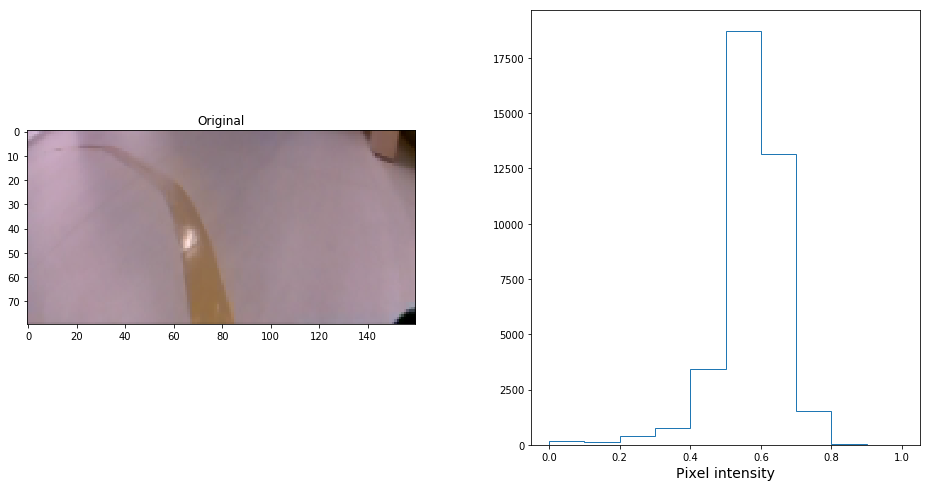

In [7]:
# Left Steer
img_left = load_image('images/left_steer.png', FRAME_H, FRAME_W, crop_from_center=False)
print(img_left.shape)
img_norm = normalize(img_left)
img_input_left = img_norm.reshape((1,) + img_norm.shape)
show_image(img_input_left[0])
pred = model.predict(img_input_left)
print('Predicted {}'.format(pred))

(80, 160, 3)
Predicted [[-0.01441441]]


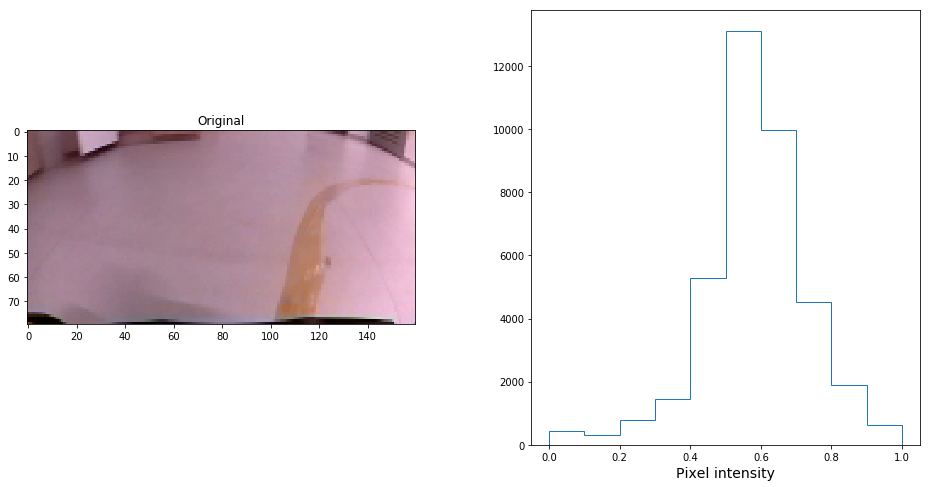

In [8]:
# Right steer
img_right = load_image('images/right_steer.png', FRAME_H, FRAME_W, crop_from_center=False)
print(img_right.shape)
img_norm = normalize(img_right)
img_input_right = img_norm.reshape((1,) + img_norm.shape)
show_image(img_input_right[0])
pred = model.predict(img_input_right)
print('Predicted {}'.format(pred))

(80, 160, 3)
Predicted [[-0.01182675]]


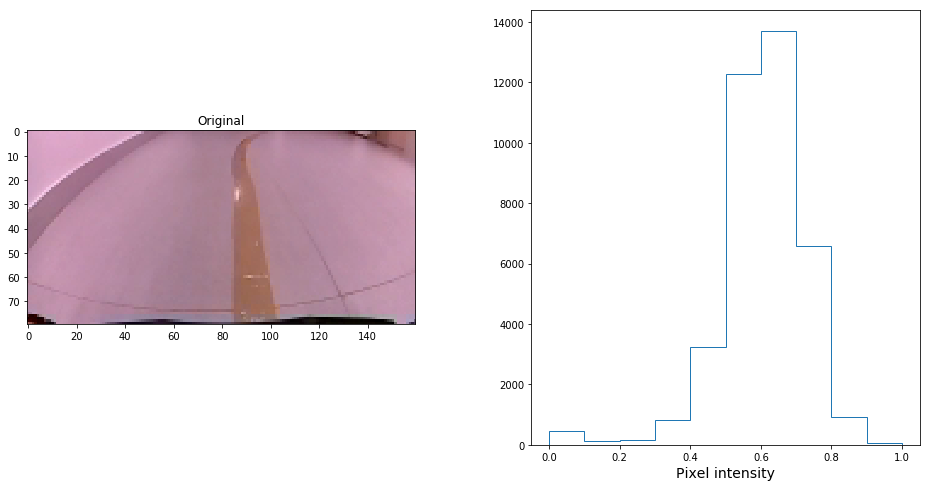

In [9]:
# Straight
img_straight = load_image('images/straight.png', FRAME_H, FRAME_W, crop_from_center=False)
print(img_straight.shape)
img_norm = normalize(img_straight)
img_input_stright = img_norm.reshape((1,) + img_norm.shape)
show_image(img_input_stright[0])
pred = model.predict(img_input_stright)
print('Predicted {}'.format(pred))

(80, 160, 3)
Predicted [[-0.01999108]]


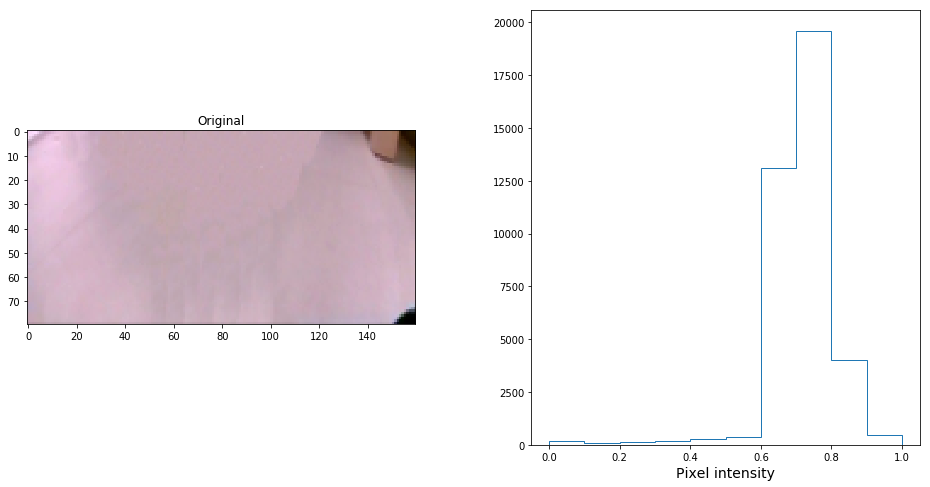

In [11]:
# Blank
img_blank = load_image('images/blank.png', FRAME_H, FRAME_W, crop_from_center=False)
print(img_blank.shape)
img_norm = normalize(img_blank)
img_input_blank = img_norm.reshape((1,) + img_norm.shape)
show_image(img_input_blank[0])
pred = model.predict(img_input_blank)
print('Predicted {}'.format(pred))

### Model Inference

We will be using "skater" to understand why the pre-trained model is suggesting a certain action. 
1. <span style="color:red">red</span> signifies positive influence
2. <span style="color:blue">blue</span> signifies positive influence

In [37]:
# Initializing Keras session
sess = tf.Session()
K.set_session(sess)

In [12]:
def infer_relevance(input_x):
    K.set_learning_phase(0)
    with DeepInterpreter(session=K.get_session()) as di:
        loaded_model = model_definition()
        # Update the model instance with the pre-trained weights
        loaded_model.load_weights('pre_trained_model/weights.hdf5')
        input_tensor = loaded_model.layers[0].input
        output_tensor = loaded_model.layers[-2].output
        print("Steering prediction {}".format(loaded_model.predict(input_x)))
        optional_args = {"window_size": 1, "step": 1}
        relevance = {
            'integrated gradient': di.explain('ig', output_tensor, input_tensor, input_x, use_case='image'),
            'e-LRP': di.explain('elrp', output_tensor, input_tensor, input_x, use_case='image'),
            'occlusion': di.explain('occlusion', output_tensor, input_tensor, input_x, use_case='image', **optional_args)
        }
    return relevance

#### 1. Computing attribution(relevance) for left steering

In [ ]:
relevance_scores = infer_relevance(img_input_left)

2018-06-03 06:59:56,922 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


Steering prediction [[-0.02664368]]


2018-06-03 06:59:58,389 - LRP - INFO - Epsilon value: 0.0001
2018-06-03 06:59:58,390 - BaseGradientMethod - INFO - Executing operations ...
2018-06-03 06:59:58,475 - Occlusion - INFO - Input shape: (80, 160, 3); window_size/step: (1/1); replace value: 0; batch size: 1
2018-06-03 06:59:58,476 - Occlusion - INFO - Shape of the mask patch: (4,)
2018-06-03 06:59:58,494 - Occlusion - INFO - shape of the default eval value :(1, 1)


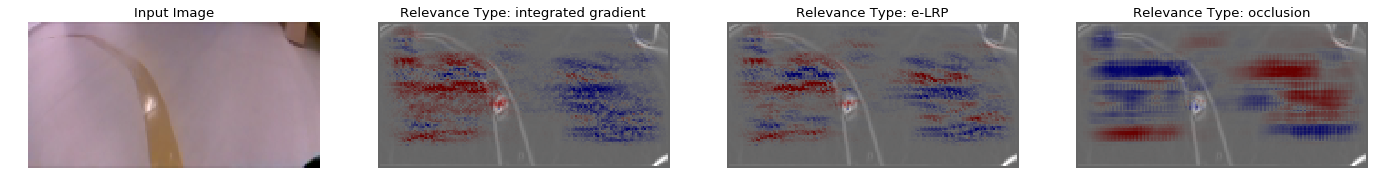

In [11]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11

img_input = img_input_left

n_cols = int(len(relevance_scores)) + 1
n_rows = len(img_input) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(img_input):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Input Image')
    ax.axis('off')
    for j, r_type in enumerate(relevance_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevance_scores[r_type][i], original_input_img=xi, axis=axj, 
                  percentile=99, alpha_edges=1, alpha_bgcolor=0.4).set_title("Relevance Type: {}".format(r_type))

#### 2. Computing attribution(relevance) for right steering

2018-06-03 06:13:10,719 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


Steering prediction [[-0.01441441]]


2018-06-03 06:13:12,216 - LRP - INFO - Epsilon value: 0.0001
2018-06-03 06:13:12,217 - BaseGradientMethod - INFO - Executing operations ...
2018-06-03 06:13:12,317 - Occlusion - INFO - Input shape: (80, 160, 3); window_size/step: (1/1); replace value: 0; batch size: 1
2018-06-03 06:13:12,318 - Occlusion - INFO - Shape of the mask patch: (4,)
2018-06-03 06:13:12,339 - Occlusion - INFO - shape of the default eval value :(1, 1)
2018-06-03 06:14:05,400 - Occlusion - INFO - Min/Max normalizer weight: 1/160
2018-06-03 06:14:05,401 - Occlusion - INFO - relevance score matrix shape :(1, 80, 160, 3)


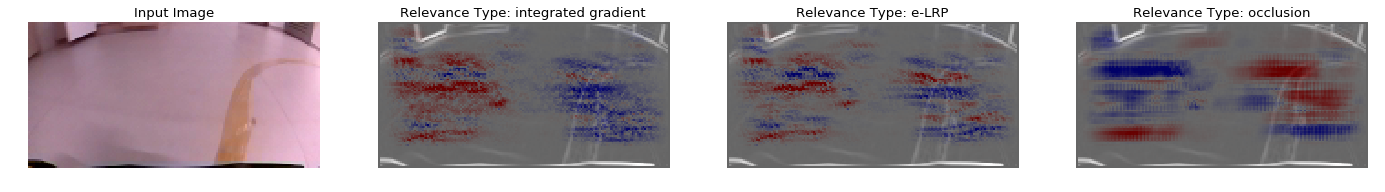

In [32]:
infer_relevance(img_input_right)
        
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11

img_input = img_input_right
n_cols = int(len(relevance_scores)) + 1
n_rows = len(img_input) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(img_input):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Input Image')
    ax.axis('off')
    for j, r_type in enumerate(relevance_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevance_scores[r_type][i], original_input_img=xi, axis=axj, 
                  percentile=99, alpha_edges=1, alpha_bgcolor=0.4).set_title("Relevance Type: {}".format(r_type))

#### 3. Computing attribution(relevance) for almost straight path

2018-06-03 06:15:38,889 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


Steering prediction [[-0.01182675]]


2018-06-03 06:15:40,383 - LRP - INFO - Epsilon value: 0.0001
2018-06-03 06:15:40,384 - BaseGradientMethod - INFO - Executing operations ...
2018-06-03 06:15:40,487 - Occlusion - INFO - Input shape: (80, 160, 3); window_size/step: (1/1); replace value: 0; batch size: 1
2018-06-03 06:15:40,488 - Occlusion - INFO - Shape of the mask patch: (4,)
2018-06-03 06:15:40,510 - Occlusion - INFO - shape of the default eval value :(1, 1)
2018-06-03 06:16:33,196 - Occlusion - INFO - Min/Max normalizer weight: 1/160
2018-06-03 06:16:33,196 - Occlusion - INFO - relevance score matrix shape :(1, 80, 160, 3)


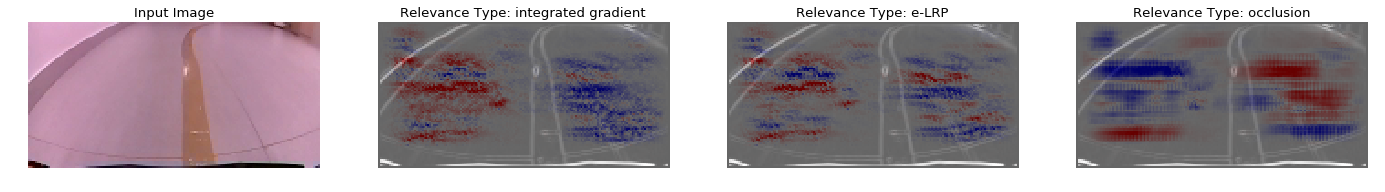

In [33]:
infer_relevance(img_input_stright)
        
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11

img_input = img_input_stright
n_cols = int(len(relevance_scores)) + 1
n_rows = len(img_input) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(img_input):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Input Image')
    ax.axis('off')
    for j, r_type in enumerate(relevance_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevance_scores[r_type][i], original_input_img=xi, axis=axj, 
                  percentile=99, alpha_edges=1, alpha_bgcolor=0.4).set_title("Relevance Type: {}".format(r_type))

#### 4. Computing attribution(relevance) for blank input with no specific path

2018-06-03 06:16:50,387 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


Steering prediction [[-0.01999108]]


2018-06-03 06:16:51,890 - LRP - INFO - Epsilon value: 0.0001
2018-06-03 06:16:51,891 - BaseGradientMethod - INFO - Executing operations ...
2018-06-03 06:16:51,998 - Occlusion - INFO - Input shape: (80, 160, 3); window_size/step: (1/1); replace value: 0; batch size: 1
2018-06-03 06:16:51,999 - Occlusion - INFO - Shape of the mask patch: (4,)
2018-06-03 06:16:52,022 - Occlusion - INFO - shape of the default eval value :(1, 1)
2018-06-03 06:17:45,625 - Occlusion - INFO - Min/Max normalizer weight: 1/160
2018-06-03 06:17:45,626 - Occlusion - INFO - relevance score matrix shape :(1, 80, 160, 3)


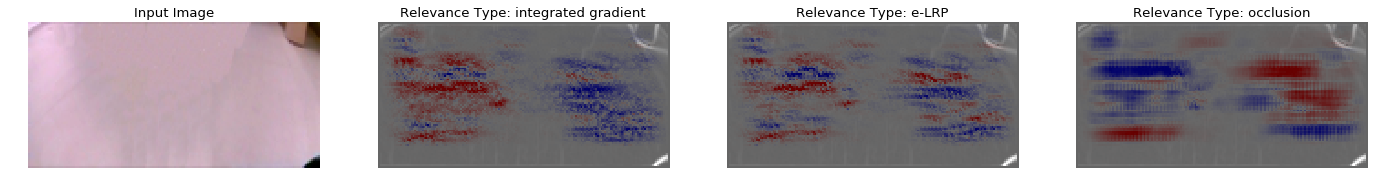

In [34]:
infer_relevance(img_input_blank)
        
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11

img_input = img_input_blank
n_cols = int(len(relevance_scores)) + 1
n_rows = len(img_input) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(img_input):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Input Image')
    ax.axis('off')
    for j, r_type in enumerate(relevance_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevance_scores[r_type][i], original_input_img=xi, axis=axj, 
                  percentile=99, alpha_edges=1, alpha_bgcolor=0.4).set_title("Relevance Type: {}".format(r_type))